# Insuline simulator

The goal of this project is to improve the quality of life for individuals with type 1 diabetes. We focus on simulating food and carbohydrate intake to automatically deliver the appropriate insulin dose when needed, ensuring that glucose levels are consistently kept within a healthy range.
### System Methodology

To train our RL agent safely and efficiently, we have constructed a digital simulation environment using the `simglucose` library, a validated simulator that models the complex dynamics of glucose in the human body. The key to our system is a "wrapper" class that adapts this simulation to the standardized interface of `gymnasium`, the industry standard for RL environments.

This environment defines the "playground" for our AI and is composed of the following elements:

1.  **Environment Construction**: Upon starting a simulation, the system configures a complete virtual scenario. A virtual patient is selected from a set of predefined profiles, each with its own physiological parameters. Next, the simulated devices are initialized: a Continuous Glucose Monitor (CGM), which acts as the agent's "eyes," and an insulin pump, which serves as its "hands." Finally, a meal scenario is introduced to simulate carbohydrate intake.

2.  **Interaction and Learning**: The training occurs in discrete 5-minute cycles. In each step:
    * The agent **observes** the current glucose level, $G(t)$.
    * Based on this observation, it decides on an **action**: the insulin dose to be administered.
    * The environment receives this action, the simulation advances by 5 minutes, and `simglucose` calculates the new glucose level, $G(t+5)$, accounting for both the injected insulin and the effect of meals.
    * The agent receives a **reward**: a positive score is awarded for maintaining glucose within the target range, while states of hypoglycemia and hyperglycemia are heavily penalized.

Through thousands of these "trial-and-error" cycles, the agent learns to associate specific glucose levels with optimal insulin doses, with the ultimate goal of maximizing its cumulative reward and, therefore, maintaining the virtual patient's glycemic stability. This project represents a step towards more intelligent, dynamic, and personalized diabetes control systems.

### Why simglucose?

This is the main engine of the simulation. It provides the mathematical models for:

* **T1DPatient:** Simulates the physiology of a patient with type 1 diabetes (how their body reacts to insulin, carbohydrates, etc.).
* **CGMSensor:** Simulates a Continuous Glucose Monitor (CGM), which measures the patient's glucose level.
* **InsulinPump:** Simulates an insulin pump, the device that administers insulin.


In [1]:
!pip install matplotlib numpy simglucose


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from simglucose.envs.simglucose_gym_env import T1DSimEnv
from simglucose.simulation.scenario import Scenario

To discretize glucose we define 4 levels for glucose and 3 levels for the velocity of glucose change.
Lower levels are for lower glucose, the velocity acts as a factor to be added in case of a positive change (more velocity=adding more).

In [3]:
def discretize_glucose(glucose, glucose_velocity, bins=[70, 120, 180]):
    # Bins: <70, 70-120, 120-180, >180
    if glucose < 70:
        glucose_level = 0
    elif glucose < 120:
        glucose_level = 1
    elif glucose < 180:
        glucose_level = 2
    else:
        glucose_level = 3

    if glucose_velocity < -5: # fast down
        velocity_level = 0
    elif glucose_velocity > 5: # fast up
        velocity_level = 2
    else:
        velocity_level = 1


    return glucose_level * 3 + velocity_level

In [4]:
action_space = np.arange(0, 2, 0.5) # e.g. 0, 0.5, ..., 6
n_actions = len(action_space)
n_states = 12 # 4 level of glucose * 3 levels of velocity

The reward function is a Gaussian centered in 115 mg/dL, with a standard deviation of 25 mg/dL. Since the most problematic case is hypoglycemia, we penalize it more heavily than hyperglycemia.

In [5]:
def reward_fn(glucose):
    mu = 115
    sigma = 25
    reward = np.exp(-0.5 * ((glucose - mu) / sigma) ** 2)
    if glucose < 70:
        reward -= 2000.0
    return reward

In [6]:
class TDControlAgent:
    def __init__(self, n_states, n_actions, gamma=0.99, lr=0.1, alg="qlearning"):
        self.gamma = gamma
        self.lr = lr
        self.n_states = n_states
        self.n_actions = n_actions
        self.Qvalues = np.zeros((n_states, n_actions))
        self.alg = alg # "sarsa" or "qlearning"

    def get_action_epsilon_greedy(self, s, eps):
        if np.random.rand() < eps:
            return np.random.randint(self.n_actions)
        else:
            best_value = np.max(self.Qvalues[s])
            best_actions = (self.Qvalues[s] == best_value)
            prob_actions = best_actions / np.sum(best_actions)
            return np.random.choice(self.n_actions, p=prob_actions)
        
    # Compute expected Q value under the epsilon-greedy policy at state new_s.
    # Each action has probability ε / n_actions, except the best one which gets (1 - ε) + ε / n_actions.
    # This reduces variance compared to SARSA by averaging over all possible next actions.   
    def epsilon_greedy_policy(self, s, eps):
        policy = np.ones(self.n_actions) * (eps / self.n_actions)
        best_action = np.argmax(self.Qvalues[s])
        policy[best_action] += (1.0 - eps)
        return policy
    
    def single_step_update(self, s, a, r, new_s, new_a=None, done=False, eps=None):
        if self.alg == "sarsa":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                deltaQ = r + self.gamma * self.Qvalues[new_s, new_a] - self.Qvalues[s, a]
        elif self.alg == "qlearning":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                deltaQ = r + self.gamma * np.max(self.Qvalues[new_s]) - self.Qvalues[s, a]
        elif self.alg == "expected_sarsa":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                if eps is None:
                    raise ValueError("Expected Sarsa needs eps")
                policy = self.epsilon_greedy_policy(new_s, eps)
                expected_value = np.sum(policy * self.Qvalues[new_s])
                deltaQ = r + self.gamma * expected_value - self.Qvalues[s, a]
            raise ValueError("Unknown algorithm")
        else:
            raise ValueError("Unknown algorithm")
        self.Qvalues[s, a] += self.lr * deltaQ

## Q-learning TD(0)

Here, and also the next time we will initialize an environment, we are considering a specific patient profile (`"adolescent#001"`) with randomized meal scenarios. The agent will learn to manage insulin delivery based on the glucose levels observed from the CGM sensor.

In [7]:
env = T1DSimEnv()
agent = TDControlAgent(n_states=n_states, n_actions=n_actions, gamma=0.99, lr=0.05, alg="qlearning")
epsilon = 0.1
num_episodes = 5000
performance = np.zeros(num_episodes)

This cell is for the training, it takes a long time so if you want you can skip it and use the pre-trained model 2 cells below.

In [7]:
for episode in range(num_episodes):
    obs = env.reset()
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    else:
        glucose = obs[0] if isinstance(obs, (np.ndarray, list)) else obs

    # Initialize velocity and state
    glucose_velocity = 0
    s = discretize_glucose(glucose, glucose_velocity)
    a = agent.get_action_epsilon_greedy(s, epsilon)

    done = False
    while not done:
        # Agent takes an action
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs, done = step_result, False

        # Extract next glucose reading
        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        else:
            next_glucose = next_obs[0] if isinstance(next_obs, (np.ndarray, list)) else next_obs

        # Calculate velocity
        glucose_velocity = next_glucose - glucose

        # Get reward and new state
        r = reward_fn(next_glucose)
        performance[episode] += r
        new_s = discretize_glucose(next_glucose, glucose_velocity)

        # --- COMBINED UPDATE AND DECISION LOGIC ---

        # 1. Agent updates its knowledge
        agent.single_step_update(s, a, r, new_s, done=done)

        # 2. Decide the next action with the FORCED WAIT rule
        if action_space[a] > 0:
            a_next = 0  # If we just injected, the next action is 0
        else:
            a_next = agent.get_action_epsilon_greedy(new_s, epsilon)

        # 3. Final safety rule
        if next_glucose < 120: # If glucose is < 120 mg/dL
            a_next = 0

        # 4. Update variables for the next loop iteration
        glucose = next_glucose
        s = new_s
        a = a_next

    # Print progress every 500 episodes
    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

print("\nAdvanced training complete.")

Episode 500/5000 completed.
Episode 1000/5000 completed.
Episode 1500/5000 completed.
Episode 2000/5000 completed.
Episode 2500/5000 completed.
Episode 3000/5000 completed.
Episode 3500/5000 completed.
Episode 4000/5000 completed.
Episode 4500/5000 completed.
Episode 5000/5000 completed.

Advanced training complete.


In [8]:
np.save('q_table.npy', agent.Qvalues)
print("Model (Table Q) saved correctly in 'q_table.npy'!")

Model (Table Q) saved correctly in 'q_table.npy'!


To see how the model performs, we have a look at the insuline level during more or less half a day.

Scenario of meals generated:
{'time': [np.float64(440.0), np.float64(685.0), np.float64(916.0), np.float64(1061.0)], 'amount': [65, 75, 3, 49]}


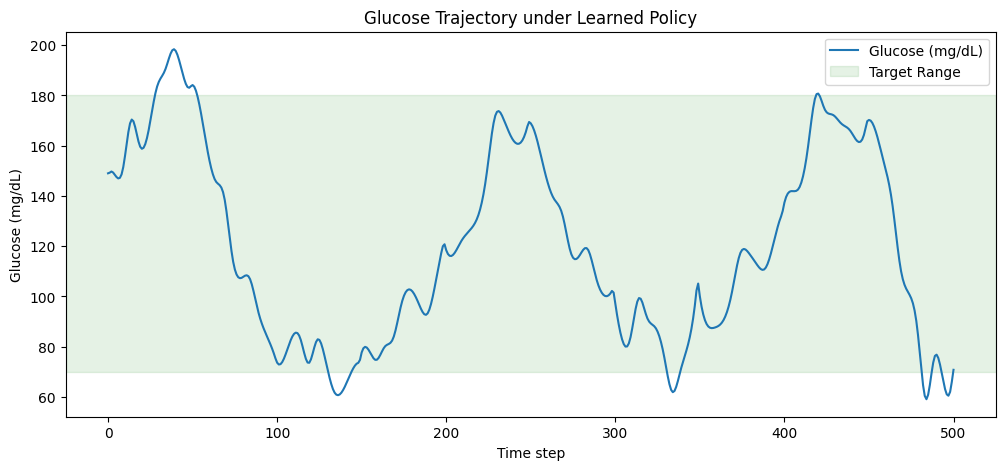

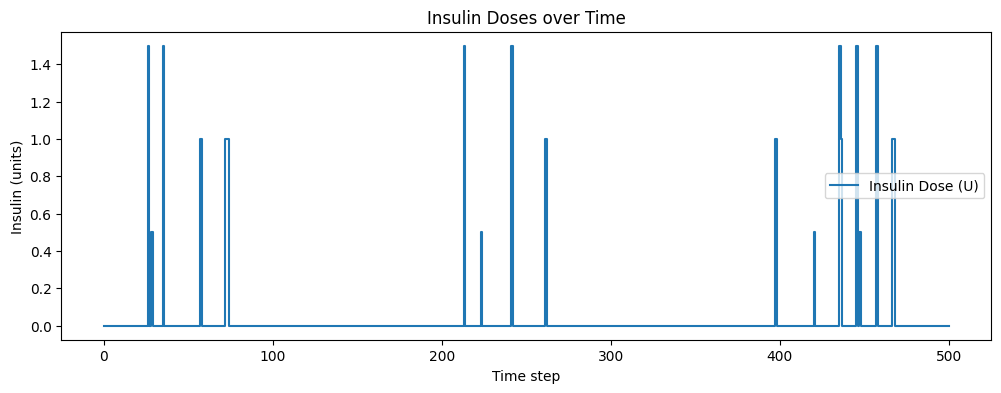

In [36]:
import matplotlib.pyplot as plt

agent_test = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent_test.Qvalues = np.load('q_table.npy')
# Set epsilon=0 for greedy policy (pure exploitation)
epsilon_eval = 0.1

# Start a new episode
obs = env.reset()

# # Access the scenario generator from the underlying environment
scenario_generator = env.env.scenario

print("Scenario of meals generated:")

# Access the 'meal' key from the scenario dictionary
print(scenario_generator.scenario['meal'])
if isinstance(obs, tuple):
    obs = obs[0]
if hasattr(obs, "CGM"):
    glucose = obs.CGM
elif isinstance(obs, dict) and 'CGM' in obs:
    glucose = obs['CGM']
elif isinstance(obs, (np.ndarray, list)):
    glucose = obs[0]
elif isinstance(obs, (float, int)):
    glucose = obs
else:
    raise ValueError(f"Unknown observation format: {type(obs)}")

glucose_velocity = 0
s = discretize_glucose(glucose, glucose_velocity)
a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
done = False

# Lists to record data
G_t = [glucose]
I_t = [action_space[a]]
rewards = []
times = [0]
t = 0

while not done and t < 500:
    insulin_dose = action_space[a]
    step_result = env.step(insulin_dose)
    if isinstance(step_result, tuple) and len(step_result) == 4:
        next_obs, _, done, info = step_result
    else:
        next_obs = step_result
        done = False

    if hasattr(next_obs, "CGM"):
        next_glucose = next_obs.CGM
    elif isinstance(next_obs, dict) and 'CGM' in next_obs:
        next_glucose = next_obs['CGM']
    elif isinstance(next_obs, (np.ndarray, list)):
        next_glucose = next_obs[0]
    elif isinstance(next_obs, (float, int)):
        next_glucose = next_obs
    else:
        raise ValueError(f"Unknown observation format: {type(next_obs)}")

    glucose_velocity = next_glucose - glucose
    new_s = discretize_glucose(next_glucose, glucose_velocity)
    r = reward_fn(next_glucose)
    rewards.append(r)
    G_t.append(next_glucose)
    I_t.append(insulin_dose)
    t += 1
    times.append(t)

    glucose = next_glucose
    s = new_s
    a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
    if next_glucose < 120:  # Safety rule
        a = 0  # Ensure no insulin is given if glucose is below 120

# Plot glucose over time
plt.figure(figsize=(12,5))
plt.plot(times, G_t, label='Glucose (mg/dL)')
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory under Learned Policy')
plt.legend()
plt.show()

# Optional: Plot insulin doses
plt.figure(figsize=(12,4))
plt.step(times, I_t, label='Insulin Dose (U)', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses over Time')
plt.legend()
plt.show()

## Q-learning TD(1)

This is the case in which we wait for the end of the episode to update.

In [14]:
env = T1DSimEnv()
agent = TDControlAgent(n_states=n_states, n_actions=n_actions, gamma=0.99, lr=0.05, alg="qlearning")
epsilon = 0.1
num_episodes = 5000
performance = np.zeros(num_episodes)

In [10]:
for episode in range(num_episodes):
    obs = env.reset()
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    else:
        glucose = obs[0] if isinstance(obs, (np.ndarray, list)) else obs

    glucose_velocity = 0
    s = discretize_glucose(glucose, glucose_velocity)
    a = agent.get_action_epsilon_greedy(s, epsilon)
    done = False
    trajectory = []

    # Get the episode
    while not done:
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs, done = step_result, False

        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        else:
            next_glucose = next_obs[0] if isinstance(next_obs, (np.ndarray, list)) else next_obs

        glucose_velocity = next_glucose - glucose
        r = reward_fn(next_glucose)
        performance[episode] += r
        new_s = discretize_glucose(next_glucose, glucose_velocity)

        # Action
        if action_space[a] > 0:
            a_next = 0
        else:
            a_next = agent.get_action_epsilon_greedy(new_s, epsilon)
        if next_glucose < 120:
            a_next = 0

        # Save transition (s, a, r)
        trajectory.append((s, a, r))

        glucose = next_glucose
        s = new_s
        a = a_next

    # Montecarlo update
    G = 0
    gamma = agent.gamma
    # For each transition starting from the end
    for t in reversed(range(len(trajectory))):
        s, a, r = trajectory[t]
        G = r + gamma * G  # Cumulative return
        agent.Qvalues[s, a] += agent.lr * (G - agent.Qvalues[s, a])

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

print("\nTraining Monte Carlo (TD(1)) completed.")

Episode 500/5000 completed.
Episode 1000/5000 completed.
Episode 1500/5000 completed.
Episode 2000/5000 completed.
Episode 2500/5000 completed.
Episode 3000/5000 completed.
Episode 3500/5000 completed.
Episode 4000/5000 completed.
Episode 4500/5000 completed.
Episode 5000/5000 completed.

Training Monte Carlo (TD(1)) completed.


In [11]:
np.save('q1_table.npy', agent.Qvalues)
print("Model (Table Q) saved correctly in 'q1_table.npy'!")

Model (Table Q) saved correctly in 'q1_table.npy'!


Scenario of meals generated:
{'time': [np.float64(518.0), np.float64(710.0), np.float64(1078.0)], 'amount': [40, 70, 101]}


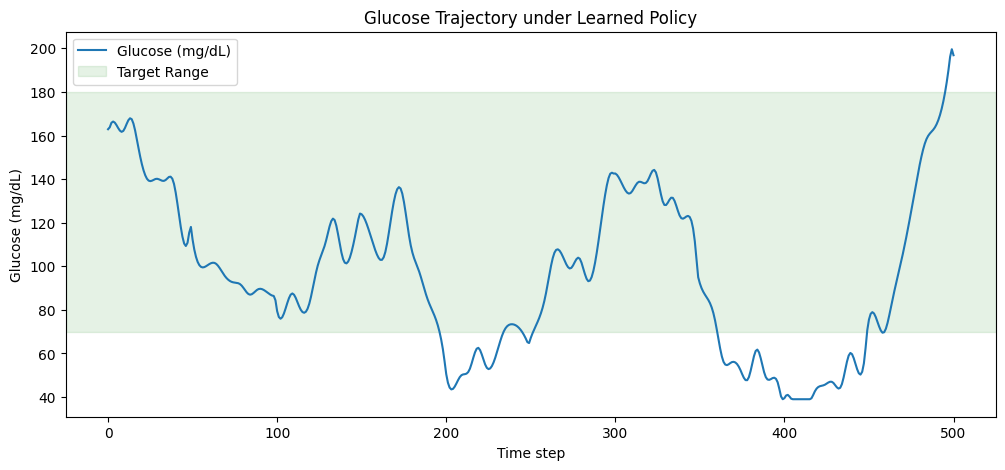

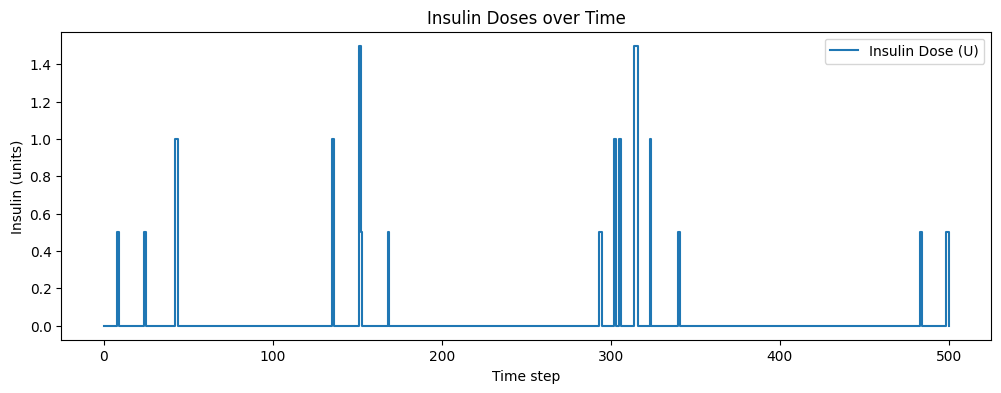

In [69]:
agent_test = TDControlAgent(n_states=n_states, n_actions=n_actions)
agent_test.Qvalues = np.load('q1_table.npy')
# Set epsilon=0 for greedy policy (pure exploitation)
epsilon_eval = 0.1

# Start a new episode
obs = env.reset()

# # Access the scenario generator from the underlying environment
scenario_generator = env.env.scenario

print("Scenario of meals generated:")

# Access the 'meal' key from the scenario dictionary
print(scenario_generator.scenario['meal'])
if isinstance(obs, tuple):
    obs = obs[0]
if hasattr(obs, "CGM"):
    glucose = obs.CGM
elif isinstance(obs, dict) and 'CGM' in obs:
    glucose = obs['CGM']
elif isinstance(obs, (np.ndarray, list)):
    glucose = obs[0]
elif isinstance(obs, (float, int)):
    glucose = obs
else:
    raise ValueError(f"Unknown observation format: {type(obs)}")

glucose_velocity = 0
s = discretize_glucose(glucose, glucose_velocity)
a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
done = False

# Lists to record data
G_t = [glucose]
I_t = [action_space[a]]
rewards = []
times = [0]
t = 0

while not done and t < 500:
    insulin_dose = action_space[a]
    step_result = env.step(insulin_dose)
    if isinstance(step_result, tuple) and len(step_result) == 4:
        next_obs, _, done, info = step_result
    else:
        next_obs = step_result
        done = False

    if hasattr(next_obs, "CGM"):
        next_glucose = next_obs.CGM
    elif isinstance(next_obs, dict) and 'CGM' in next_obs:
        next_glucose = next_obs['CGM']
    elif isinstance(next_obs, (np.ndarray, list)):
        next_glucose = next_obs[0]
    elif isinstance(next_obs, (float, int)):
        next_glucose = next_obs
    else:
        raise ValueError(f"Unknown observation format: {type(next_obs)}")

    glucose_velocity = next_glucose - glucose
    new_s = discretize_glucose(next_glucose, glucose_velocity)
    r = reward_fn(next_glucose)
    rewards.append(r)
    G_t.append(next_glucose)
    I_t.append(insulin_dose)
    t += 1
    times.append(t)

    glucose = next_glucose
    s = new_s
    a = agent_test.get_action_epsilon_greedy(s, epsilon_eval)
    if next_glucose < 120:  # Safety rule
        a = 0  # Ensure no insulin is given if glucose is below 120

# Plot glucose over time
plt.figure(figsize=(12,5))
plt.plot(times, G_t, label='Glucose (mg/dL)')
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory under Learned Policy')
plt.legend()
plt.show()

# Optional: Plot insulin doses
plt.figure(figsize=(12,4))
plt.step(times, I_t, label='Insulin Dose (U)', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses over Time')
plt.legend()
plt.show()

#### PID Controller

The controller's action ($u(t)$) is calculated by summing three components based on the "error" ($e(t)$), which is the difference between the desired value and the current value.

* PID Controller Formula

$$u(t) = K_p e(t) + K_i \int_{0}^{t} e(\tau) d\tau + K_d \frac{de(t)}{dt}$$

* Brief Explanation of Each Term:

    * **Proportional Term (P):** `Kp * e(t)`
        * It reacts to the **present** error. If the error is large now, the action is large. It provides the main, immediate response.

    * **Integral Term (I):** `Ki * ∫e(t)dt`
        * It corrects the error accumulated in the **past**. This term eliminates small, persistent deviations over time.

    * **Derivative Term (D):** `Kd * de(t)/dt`
        * It anticipates **future** error based on its rate of change. If the error is decreasing rapidly, this term acts as a "brake" to prevent overshooting the target.

In summary, the controller combines a reaction to the **present (P)**, a correction for the **past (I)**, and a prediction of the **future (D)** to achieve stable and precise control.

In [63]:
class PIDController:
    """
    A Proportional-Integral-Derivative (PID) controller designed to work with
    a discrete action space, making it comparable to a Reinforcement Learning agent.
    """
    def __init__(self, Kp, Ki, Kd, target_glucose=115.0, sample_time=1, max_insulin=2., min_insulin=0.0):
        """
        Initializes the PID controller's parameters.

        Args:
            Kp (float): The Proportional gain.
            Ki (float): The Integral gain.
            Kd (float): The Derivative gain.
            target_glucose (float): The desired glucose level setpoint.
            sample_time (int): The time in minutes between each controller step.
            max_insulin (float): The maximum allowed insulin dose.
            min_insulin (float): The minimum allowed insulin dose.
        """
        # --- Controller Gains ---
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        
        # --- Controller Setpoints and Limits ---
        self.target_glucose = target_glucose
        self.sample_time = sample_time
        self.max_insulin, self.min_insulin = max_insulin, min_insulin
        
        # --- Controller State Variables ---
        self.integral_error = 0.0 # Accumulates past errors
        self.last_error = 0.0     # The error from the previous time step
        self.last_output = 0.0    # The last calculated continuous output (for anti-windup)

    def compute(self, current_glucose, action_space):
        """
        Calculates the ideal insulin dose based on the current glucose,
        and then discretizes the output to match the RL agent's action space.

        Args:
            current_glucose (float): The continuous glucose reading from the environment.
            action_space (np.array): The array of possible discrete actions (e.g., [0.0, 0.5, 1.0]).

        Returns:
            float: The chosen discrete insulin dose.
        """
        # 1. The PID uses the CONTINUOUS GLUCOSE value to calculate the error.
        #    This is essential for the formula to work correctly.
        error = current_glucose - self.target_glucose

        # 2. Calculate the ideal continuous dose by summing the P, I, and D terms.
        
        # Proportional Term: Reacts to the current error.
        p_term = self.Kp * error
        
        # Integral Term: Corrects for past, accumulated errors.
        # Includes an "anti-windup" check: only accumulate error if the pump is not saturated.
        if self.min_insulin < self.last_output < self.max_insulin:
            self.integral_error += error * self.sample_time
        i_term = self.Ki * self.integral_error
        
        # Derivative Term: Anticipates future error based on the rate of change.
        derivative_error = (error - self.last_error) / self.sample_time
        d_term = self.Kd * derivative_error
        
        # Sum the terms to get the ideal continuous output.
        continuous_output = p_term + i_term + d_term
        
        # Clamp the output to the pump's physical limits.
        continuous_output = max(self.min_insulin, min(self.max_insulin, continuous_output))
        
        # 3. DISCRETIZE THE OUTPUT to make it comparable to the RL agent.
        #    Find the index of the action in the action_space that is closest to our ideal continuous dose.
        closest_action_index = np.argmin(np.abs(action_space - continuous_output))
        # Select that discrete dose from the action space.
        discrete_output = action_space[closest_action_index]

        # 4. Update the controller's state for the next iteration.
        self.last_error = error
        self.last_output = continuous_output # Save the continuous output for the anti-windup logic
        
        return discrete_output

    def reset(self):
        """
        Resets the internal state of the controller.
        This should be called at the beginning of each new simulation episode.
        """
        self.integral_error = 0.0
        self.last_error = 0.0
        self.last_output = 0.0

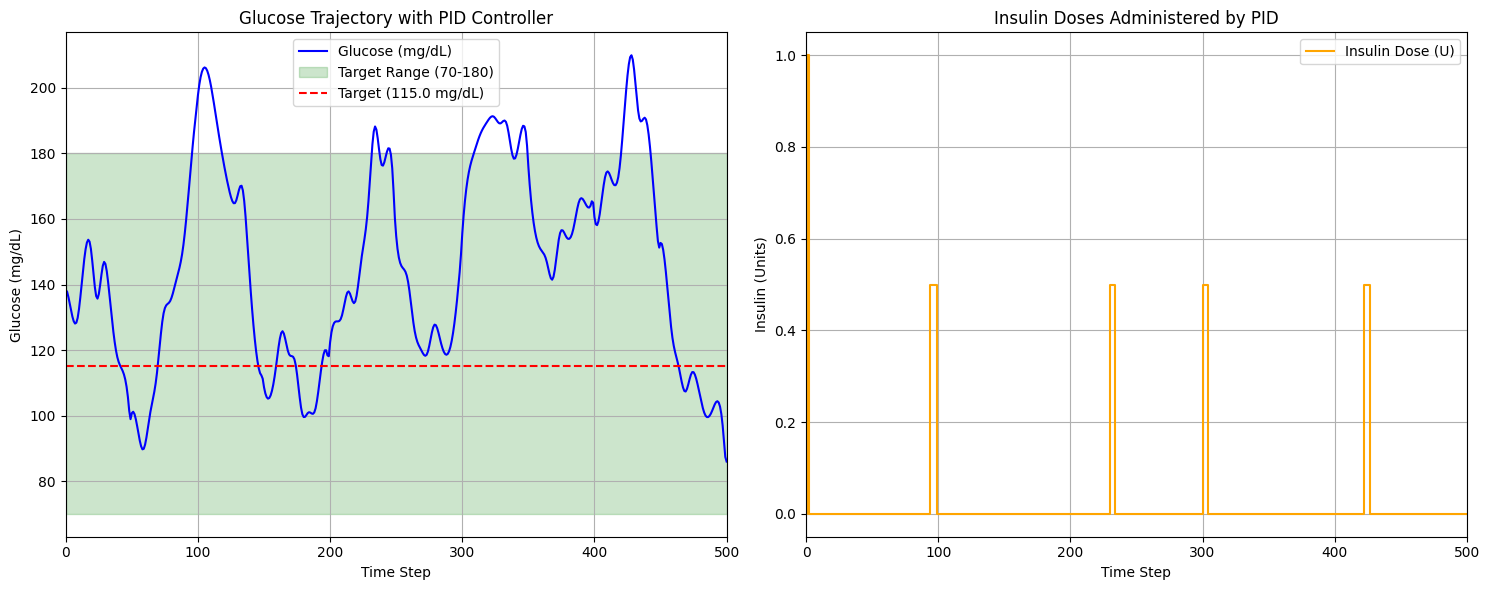

In [112]:
# --- 1. Initialization ---
action_space = np.arange(0, 2., 0.5)
kp_gain = 0.0006   
ki_gain = 0.000001 
kd_gain = 0.05     

# Ensure the PIDController class is defined in a cell above this one
pid_controller = PIDController(Kp=kp_gain, Ki=ki_gain, Kd=kd_gain, target_glucose=115.0)
env_test = T1DSimEnv()
obs = env_test.reset()
pid_controller.reset()

# --- Initial Glucose Logic ---

if isinstance(obs, tuple):
    obs = obs[0]
glucose = obs.CGM if hasattr(obs, "CGM") else obs

# --- 2. Simulation Loop  ---

times = [0]
glucose_history = [glucose]
insulin_history = [0] 

for t in range(500):
    # Compute the discrete insulin dose
    insulin_dose = pid_controller.compute(glucose, action_space)
    
    # Take a step in the environment
    try:
        step_result, _, done, _ = env_test.step(insulin_dose)
        next_glucose = step_result.CGM if hasattr(step_result, "CGM") else step_result
    except Exception as e:
        print(f"Simulation stopped due to an error at step {t+1}: {e}")
        break

    if next_glucose < 120:  # Safety rule
        insulin_dose = 0  # Ensure no insulin is given if glucose is below 120

    # Record data for this step
    times.append(t + 1) 
    glucose_history.append(next_glucose)
    insulin_history.append(insulin_dose)
    
    # Update glucose for the next iteration
    glucose = next_glucose
    
    # If the environment signals 'done', we exit the loop immediately.
    # No more data filling.
    if done:
        
        break 


plt.figure(figsize=(15, 6))

# Glucose Plot
plt.subplot(1, 2, 1)
plt.plot(times, glucose_history, label='Glucose (mg/dL)', color='blue')
plt.axhspan(70, 180, color='green', alpha=0.2, label='Target Range (70-180)')
plt.axhline(pid_controller.target_glucose, color='red', linestyle='--', label=f'Target ({pid_controller.target_glucose} mg/dL)')
plt.xlabel('Time Step') 
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory with PID Controller')
plt.legend()
plt.grid(True)
plt.xlim(0, 500)
# Insulin Plot
plt.subplot(1, 2, 2)
# We use times[:-1] and insulin_history[:-1] to match the lengths for a step plot
plt.step(times[:-1], insulin_history[:-1], label='Insulin Dose (U)', where='post', color='orange')
plt.xlabel('Time Step') 
plt.ylabel('Insulin (Units)')
plt.title('Insulin Doses Administered by PID')
plt.legend()
plt.grid(True)
plt.xlim(0, 500)
plt.tight_layout()
plt.show()

After designing and tuning a classic PID controller, we now have a solid baseline to properly evaluate the performance of our Reinforcement Learning (RL) agent. The direct comparison highlights the limitations of fixed-rule systems and showcases the power of the adaptive, learned policy developed by the RL agent.

The final version of our PID controller resulted in the following behavior:

  * **A Safe but Suboptimal Baseline:** The controller is very conservative. It successfully keeps the patient's glucose level entirely within the safe "Target Range" (70-180 mg/dL), completely avoiding hypoglycemia. This makes it a **safe** controller.
  * **Ineffective Glycemic Control:** However, its strategy is too simple. After an initial insulin dose, it administers no more for the rest of the simulation. This allows the glucose to remain in a sustained state of **hyperglycemia** (high blood sugar), never making an effort to guide it towards the optimal target of 115 mg/dL.

This PID controller serves its purpose as a benchmark: it is safe, but not effective at achieving tight glycemic control.

**Analysis of the Reinforcement Learning Agent's Performance**

In stark contrast, the policy learned by the RL agent demonstrates a much more effective and intelligent control strategy, as seen in the test results from this notebook.

  * **Effective and Active Control:** The RL agent actively works to bring the glucose level down after a meal. Instead of letting it drift in the upper part of the safe range, the agent successfully steers the glucose towards the 115 mg/dL target.
  * **Intelligent Dosing Strategy:** The insulin dosing graph for the RL agent shows a more complex and responsive policy. The agent learns when to administer insulin and, crucially, when to stop, thus avoiding the severe hypoglycemic crashes that plagued our initial PID tuning attempts. It has learned a more nuanced approach than the PID's fixed mathematical formula.

While the PID controller provides a safe baseline, its performance is minimal. The **Reinforcement Learning agent is clearly the superior approach** for this complex control task.

The RL agent excels because it moves beyond a rigid set of rules. Through its training over thousands of simulated episodes, it has learned the complex and delayed dynamics of the glucose-insulin system. It learned how to be aggressive enough to counteract hyperglycemia from meals, yet cautious enough to avoid the subsequent hypoglycemic crash.

This project successfully demonstrates that an adaptive, learned approach like Reinforcement Learning can significantly outperform a classic, well-tuned controller, paving the way for more intelligent and personalized automated diabetes management systems.